## <center> Emotion Recognition via EEG (and ECG) Signal Classification: Leveraging Advanced Neural Network Algorithms </center>
---
**authors**: A. Eldesoky, Y. Gomaa and M. Ayman

**date**: xx/3/2024

---

# Dataset:
DREAMER, a multi-modal database consisting of electroencephalogram (EEG) and
electrocardiogram (ECG) signals recorded during affect elicitation by means of audio-visual stimuli.
Signals from 23 participants were recorded along with the participants’ self-assessment of their
affective state after each stimuli, in terms of valence, arousal, and dominance. All the signals were
captured using portable, wearable, wireless, low-cost and off-the-shelf equipment that has the
potential to allow the use of affective computing methods in everyday applications. The Emotiv EPOC
wireless EEG headset was used for EEG and the Shimmer2 ECG sensor for ECG.

## Dataset Description:
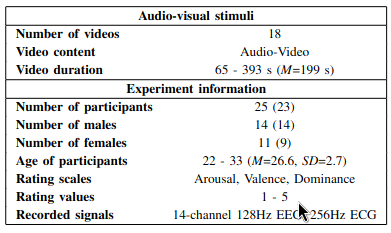
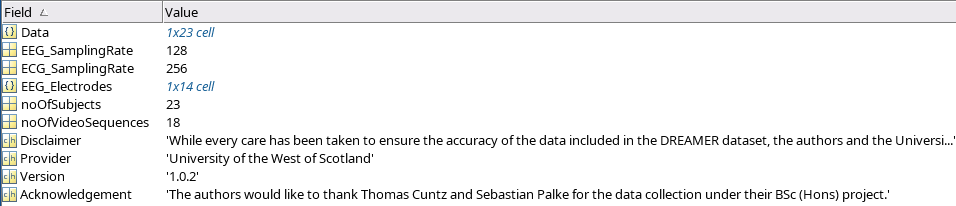

## Electroenchephalogram Signals:
The captured EEG signals were separated into the theta (4 Hz - 8 Hz), alpha (8 Hz - 13 Hz), and beta (13 Hz - 20 Hz) frequency bands. The logarithms of the PSD from each of the aforementioned bands are extracted from the signal of each of the 14 electrodes in order to be used as features
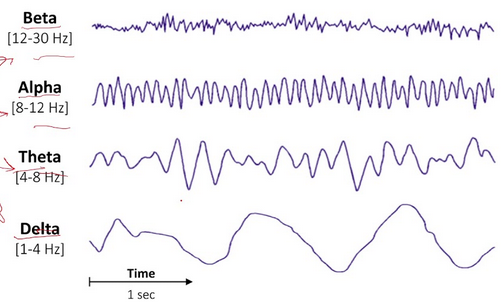


In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install glob
!pip install scipy
!pip install torch
!pip install mne
!pip install PIL


ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [2]:
!pip install scikit-learn

In [3]:
%%capture
!pip install ssqueezepy
!pip install timm
!pip install pytorch-lightning

In [4]:
!pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-m2argbh2
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-m2argbh2
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import re
import random
from PIL import Image
import pyeeg as pe

In [6]:
data = scipy.io.loadmat('data/DREAMER.mat')

In [7]:
PATIENTS = 23
VIDEOS = 18

Features = {
    'Age' : 0,
    'Gender': 1,
    'EEG' : 2,
    'ECG' : 3,
    'Valence' : 4,
    'Arousal' : 5,
    'Dominance' : 6
}


signal_types = {
    'BaseLine' :0,
    'Stimulie' :1
}


def retrieve_data(Sample_index, Feature_name, Video_idx):
    """
    Retrieve specific feature data for a given patient from the dataset.

    Parameters:
        Sample_index (int): Index of the patient (0 to 23).
        Feature_name (str): Name of the feature to retrieve. It should be one of the following:
                            'Age', 'Gender', 'EEG', 'ECG', 'Valence', 'Arousal', 'Dominance'.

    Returns:
        float: The value of the specified feature for the specified patient.

    Raises:
        KeyError: If Feature_name is not one of the supported features.
    """
    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_name]][Video_idx]

def retrieve_signals(Sample_index, Feature_type, signal_type):
    """
    Retrieve specific signal data for a given patient from the dataset.

    Parameters:
        Sample_index (int): Index of the patient (0 to 23).
        Feature_type (str): Type of feature ('EEG' or 'ECG').
        signal_type (str): Type of signal to retrieve ('BaseLine' or 'Stimulie').

    Returns:
        float: The value of the specified signal for the specified patient.

    Raises:
        ValueError: If Feature_type is not 'EEG' or 'ECG'.
    """
    if Feature_type not in ('EEG', 'ECG'):
        raise ValueError(f"Invalid Feature_type: {Feature_type}. Feature_type must be 'EEG' or 'ECG'.")

    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_type]][0][0][signal_types[signal_type]]

In [8]:
ECG_Stimuli = []
ECG_Baseline = []
EEG_Baseline = []
EEG_Stimuli = []

for i in range(PATIENTS):
    baseline = retrieve_signals(i,'ECG','BaseLine')            
    ECG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'ECG','Stimulie')            
    ECG_Stimuli.append(stimuli)
    baseline = retrieve_signals(i,'EEG','BaseLine')       
    EEG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'EEG','Stimulie')             
    EEG_Stimuli.append(stimuli)

In [9]:
big_df = pd.DataFrame()
df = pd.DataFrame()
patients = []
for i in range(PATIENTS): # for i in every patient
    for j in range(VIDEOS): # for j in every Video
        patient_index = [i] * len(EEG_Stimuli[i][j][0])
        video_index = [j] * len(EEG_Stimuli[i][j][0])
        valence = [retrieve_data(i, 'Valence', j)[0]] * len(EEG_Stimuli[i][j][0])
        arousal = [retrieve_data(i, 'Arousal', j)[0]] * len(EEG_Stimuli[i][j][0])
        dominance = [retrieve_data(i, 'Dominance', j)[0]] * len(EEG_Stimuli[i][j][0])
        electrodes = []
        for k in range(14): # for k in every electrode
            electrode = []
            for l,row  in enumerate(EEG_Stimuli[i][j][0]):
                electrode.append(row[k])
            electrodes.append(electrode)   
        Dict = {
            'patient_index' : patient_index,
            'video_index' : video_index,
            'valence' : valence,
            'arousal' : arousal,
            'dominance' : dominance
        }
        columns_list = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        for idx , key in enumerate(columns_list):
            Dict[key] = electrodes[idx]
        df = pd.DataFrame(Dict)
        patients.append(df)
big_df = pd.concat(patients)

In [10]:
big_df.video_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [11]:
big_df.patient_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [12]:
big_df

patient_index  video_index  valence  arousal  dominance          AF3  \
0                  0            0        4        3          2  4388.205128   
1                  0            0        4        3          2  4375.897436   
2                  0            0        4        3          2  4378.461538   
3                  0            0        4        3          2  4393.846154   
4                  0            0        4        3          2  4396.410256   
...              ...          ...      ...      ...        ...          ...   
23803             22           17        2        4          2  4400.000000   
23804             22           17        2        4          2  4371.794872   
23805             22           17        2        4          2  4370.256410   
23806             22           17        2        4          2  4373.846154   
23807             22           17        2        4          2  4378.461538   

                F7           F3          FC5           T7           P7  \
0      4102.564103  4219.487179  4465.128205  4370.769231  4399.487179   
1      4093.846154  4252.820513  4522.564103  4435.897436  4411.794872   
2      4091.282051  4230.256410  4488.205128  4370.256410  4402.564103   
3      4101.025641  4193.333333  4418.974359  4270.256410  4392.307692   
4      4108.717949  4210.769231  4436.410256  4310.769231  4401.025641   
...            ...          ...          ...          ...          ...   
23803  4106.153846  4163.589744  4415.897436  4311.282051  4378.974359   
23804  4100.512821  4164.102564  4406.153846  4311.282051  4381.538462   
23805  4097.948718  4155.897436  4408.205128  4313.333333  4380.000000   
23806  4087.692308  4158.461538  4409.230769  4312.307692  4376.410256   
23807  4092.307692  4165.128205  4411.794872  4316.923077  4383.589744   

                O1           O2           P8           T8          FC6  \
0      4443.076923  4023.076923  4365.128205  4310.256410  3953.846154   
1      4488.717949  4108.717949  4399.487179  4384.615385  4007.692308   
2      4461.025641  4077.435897  4378.461538  4328.717949  3986.153846   
3      4411.282051  3982.564103  4336.410256  4213.333333  3930.256410   
4      4426.666667  3980.512821  4349.743590  4238.461538  3945.128205   
...            ...          ...          ...          ...          ...   
23803  4493.333333  3957.948718  4334.871795  4299.487179  3944.102564   
23804  4490.256410  3941.538462  4311.794872  4278.974359  3920.000000   
23805  4490.256410  3945.641026  4315.384615  4274.871795  3923.589744   
23806  4489.743590  3950.256410  4321.538462  4275.384615  3921.538462   
23807  4492.307692  3954.358974  4329.230769  4287.179487  3929.743590   

                F4           F8          AF4  
0      4454.358974  4326.153846  4165.128205  
1      4466.666667  4372.820513  4247.179487  
2      4461.025641  4328.205128  4203.589744  
3      4442.564103  4261.025641  4100.000000  
4      4446.666667  4289.743590  4115.384615  
...            ...          ...          ...  
23803  4454.358974  4341.025641  4160.000000  
23804  4430.769231  4310.256410  4145.128205  
23805  4441.538462  4301.538462  4136.410256  
23806  4432.307692  4295.384615  4142.051282  
23807  4442.564103  4318.974359  4153.846154  

[10975232 rows x 19 columns]

In [13]:
grouped_df = big_df.groupby(['patient_index', 'video_index']).mean().reset_index()

In [14]:
grouped_df

patient_index  video_index  valence  arousal  dominance          AF3  \
0                0            0      4.0      3.0        2.0  4380.218460   
1                0            1      3.0      3.0        1.0  4388.493529   
2                0            2      5.0      4.0        4.0  4388.187917   
3                0            3      4.0      3.0        2.0  4393.849871   
4                0            4      4.0      4.0        4.0  4388.533271   
..             ...          ...      ...      ...        ...          ...   
409             22           13      2.0      2.0        2.0  4384.971531   
410             22           14      2.0      2.0        2.0  4382.067893   
411             22           15      3.0      3.0        2.0  4362.806357   
412             22           16      2.0      2.0        4.0  4381.298859   
413             22           17      2.0      4.0        2.0  4389.117836   

              F7           F3          FC5           T7           P7  \
0    4093.074125  4158.109156  4393.518655  4295.999831  4378.748389   
1    4103.419670  4163.580232  4410.191818  4319.132627  4354.399467   
2    4108.831372  4163.864447  4410.005238  4316.097204  4357.565806   
3    4115.479442  4179.318814  4419.010489  4306.440208  4352.845686   
4    4111.512184  4240.120192  4418.574248  4300.556155  4341.445607   
..           ...          ...          ...          ...          ...   
409  4104.184059  4167.153610  4420.616257  4317.316412  4369.968232   
410  4103.736862  4162.004987  4415.487689  4316.218534  4366.856737   
411  4092.465607  4148.741884  4406.947506  4305.184706  4365.029915   
412  4106.109776  4165.188880  4406.204818  4310.076967  4375.107516   
413  4104.688943  4165.932287  4411.251314  4312.867362  4374.321193   

              O1           O2           P8           T8          FC6  \
0    4434.144984  3955.981490  4304.093384  4256.660365  3934.476872   
1    4451.704682  3958.206382  4313.717490  4274.703495  3939.122596   
2    4451.039710  3954.966982  4309.079988  4274.770472  3937.527193   
3    4456.328101  3968.441096  4311.054386  4265.888072  3944.887121   
4    4448.318987  3984.846549  4305.414811  4261.750890  3954.639747   
..           ...          ...          ...          ...          ...   
409  4492.272813  3937.622172  4316.522012  4278.015766  3930.405849   
410  4439.508083  3935.958260  4315.734422  4276.555216  3930.494740   
411  4459.969572  3923.326204  4298.418454  4263.581710  3915.684644   
412  4442.527184  3937.405740  4314.517556  4277.634434  3925.473085   
413  4437.121437  3938.425093  4315.504075  4277.972498  3933.393300   

              F4           F8          AF4  
0    4405.790209  4285.140506  4158.345393  
1    4445.382077  4303.317185  4202.386353  
2    4461.734188  4310.371169  4201.471780  
3    4465.420770  4301.572757  4192.231160  
4    4462.130350  4292.819099  4198.149333  
..           ...          ...          ...  
409  4522.457344  4299.459135  4183.513103  
410  4510.667900  4302.228423  4186.060047  
411  4455.840134  4289.359077  4175.677166  
412  4455.151383  4304.197857  4178.936439  
413  4460.255398  4306.432873  4176.958424  

[414 rows x 19 columns]

In [15]:
channel_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])
band = [4,8,12,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22']

In [16]:
from sklearn.decomposition import FastICA
def safe_bin_power(X, band, sample_rate):
    '''
    Safely compute the bin power to avoid division by zero.
    '''
    Power, Power_Ratio = pe.bin_power(X, band, sample_rate)
    total_power = np.sum(Power)
    if total_power == 0:
        Power_Ratio = np.zeros_like(Power)
        print('power0')
    else:
        Power_Ratio = Power / total_power
    return Power, Power_Ratio
def FFT_Processing(df,channel_indices, band, window_size, step_size, sample_rate):
    '''
    arguments:  dataframe df containing data of 23 patients and 18 trials, with 14 channels each
                list channel indices
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    patient_column = df.columns[0]
    trial_column = df.columns[1]
    
    # Assuming the last three columns are the labels
    label_columns = df.columns[2:5]

    # Iterate over each unique patient and trial
    for patient in df[patient_column].unique():
        for trial in df[df[patient_column] == patient][trial_column].unique():
            # Extract data for the current trial (excluding the first two columns and the last three columns)
            trial_data = df[(df[patient_column] == patient) & (df[trial_column] == trial)]
            data = trial_data.iloc[:, 5:].values.T  # Transpose to get channels as rows
            labels = trial_data[label_columns].values[0]# Extract labels
            data = np.transpose(data)
            ica = FastICA(n_components=14,tol=1,max_iter=300)
            data_ica = ica.fit_transform(data)
            data_ica = np.transpose(data_ica)
            start = 0

            while start + window_size < data_ica.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel_indices:
                    X = data_ica[j][start: start + window_size]# Slice raw data over window_size, at interval of step_size
                    Y = safe_bin_power(X, band, sample_rate)  # FFT over the window of channel j, in seq of theta, alpha, beta, low gamma
                    meta_data.extend(Y[0])  # Append the power values

                meta_array = [np.array(meta_data), np.array(labels)]  # Create a homogeneous list
                meta.append(meta_array)

                start = start + step_size
                
    meta = np.array(meta, dtype=object)
    
    np.save('ica_out_'+str(window_size), meta, allow_pickle=True, fix_imports=True)




In [17]:
window_size = 128
step_size = 64
FFT_Processing (big_df, channel_indices, band, window_size, step_size, sample_rate)

In [17]:
window_size = 256
step_size = 128
FFT_Processing (big_df, channel_indices, band, window_size, step_size, sample_rate)

In [18]:
window_size = 640
step_size = 320
FFT_Processing (big_df, channel_indices, band, window_size, step_size, sample_rate)

window_size = 1280
step_size = 640
FFT_Processing (big_df, channel_indices, band, window_size, step_size, sample_rate)

In [ ]:
#for subjects in subjectList:
from sklearn.model_selection import train_test_split
data_training_1s = []
label_training_1s = []
data_testing_1s = []
label_testing_1s = []
data_all = []
labels_all = []
window_size = 128

with open('ica_out_128'+ '.npy', 'rb') as file:
    sub = np.load(file, allow_pickle=True)
    data = [item[0] for item in sub]
    labels = [item[1] for item in sub]
    data_all.extend(data)
    labels_all.extend(labels)

# Convert to numpy arrays for consistency
data_all = np.array(data_all)
labels_all = np.array(labels_all)
        
        # First split: train+val and test (80% train+val, 20% test)
data_training_1s, data_testing_1s, label_training_1s, label_testing_1s = train_test_split(data_all, labels_all, test_size=0.2, random_state=42)
       
       
np.save('out\ica_data_training_1s', np.array(data_training_1s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_training_1s', np.array(label_training_1s), allow_pickle=True, fix_imports=True)
print("training dataset_1s:", np.array(data_training_1s).shape, np.array(label_training_1s).shape)

np.save('out\ica_data_testing_1s', np.array(data_testing_1s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_testing_1s', np.array(label_testing_1s), allow_pickle=True, fix_imports=True)
print("testing dataset_1s:", np.array(data_testing_1s).shape, np.array(label_testing_1s).shape)

In [19]:
#for subjects in subjectList:
from sklearn.model_selection import train_test_split
data_training_2s = []
label_training_2s = []
data_testing_2s = []
label_testing_2s = []
data_all = []
labels_all = []
window_size = 256

with open('ica_out_256'+ '.npy', 'rb') as file:
    sub = np.load(file, allow_pickle=True)
    data = [item[0] for item in sub]
    labels = [item[1] for item in sub]
    data_all.extend(data)
    labels_all.extend(labels)

# Convert to numpy arrays for consistency
data_all = np.array(data_all)
labels_all = np.array(labels_all)
        
        # First split: train+val and test (80% train+val, 20% test)
data_training_2s, data_testing_2s, label_training_2s, label_testing_2s = train_test_split(data_all, labels_all, test_size=0.2, random_state=42)
       
       
np.save('out\ica_data_training_2s', np.array(data_training_2s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_training_2s', np.array(label_training_2s), allow_pickle=True, fix_imports=True)
print("training dataset_2s:", np.array(data_training_2s).shape, np.array(label_training_2s).shape)

np.save('out\ica_data_testing_2s', np.array(data_testing_2s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_testing_2s', np.array(label_testing_2s), allow_pickle=True, fix_imports=True)
print("testing dataset_2s:", np.array(data_testing_2s).shape, np.array(label_testing_2s).shape)

training dataset_2s: (67932, 56) (67932, 3)
testing dataset_2s: (16984, 56) (16984, 3)


In [20]:
#for subjects in subjectList:
from sklearn.model_selection import train_test_split
data_training_5s = []
label_training_5s = []
data_testing_5s = []
label_testing_5s = []
data_all = []
labels_all = []
window_size = 640

with open('ica_out_640'+ '.npy', 'rb') as file:
    sub = np.load(file, allow_pickle=True)
    data = [item[0] for item in sub]
    labels = [item[1] for item in sub]
    data_all.extend(data)
    labels_all.extend(labels)

# Convert to numpy arrays for consistency
data_all = np.array(data_all)
labels_all = np.array(labels_all)
        
        # First split: train+val and test (80% train+val, 20% test)
data_training_5s, data_testing_5s, label_training_5s, label_testing_5s = train_test_split(data_all, labels_all, test_size=0.2, random_state=42)
       
       
np.save('out\ica_data_training_5s', np.array(data_training_5s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_training_5s', np.array(label_training_5s), allow_pickle=True, fix_imports=True)
print("training dataset_5s:", np.array(data_training_5s).shape, np.array(label_training_5s).shape)

np.save('out\ica_data_testing_5s', np.array(data_testing_5s), allow_pickle=True, fix_imports=True)
np.save('out\ica_label_testing_5s', np.array(label_testing_5s), allow_pickle=True, fix_imports=True)
print("testing dataset_5s:", np.array(data_testing_5s).shape, np.array(label_testing_5s).shape)

training dataset_5s: (26919, 56) (26919, 3)
testing dataset_5s: (6730, 56) (6730, 3)
